AIPI 590 | Final Project
Haodong He
Purbation analysis based on LSTM for comparing XAI methods 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Haodong12/AIPI-590-Final-Project/blob/main/Final%20Project/Final_Project.ipynb)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install pandas numpy scikit-learn tensorflow keras-tuner matplotlib lime tqdm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import gradients
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm
import re
from scipy.spatial.distance import euclidean

/var/folders/yn/0mx_cpvd1wq4cvk1fn4g47q00000gp/T/ipykernel_67382/457216690.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
import zipfile
import os

In [8]:
# Path to the zip file
# zip_file_path = "/content/drive/MyDrive/AIPI 590 Final Project/PCA200.csv.zip"
zip_file_path ="/content/drive/MyDrive/AIPI 590 Final Project/PCA200.csv.zip"

# Directory to extract the contents
extract_to_path = "/content/drive/MyDrive/AIPI 590 Final Project/"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("Zip file extracted successfully.")

# Load the extracted CSV file
csv_file_path = os.path.join(extract_to_path, "PCA200.csv")  # Adjust the name if it's different
data = pd.read_csv(csv_file_path, index_col=0)

Zip file extracted successfully.


In [5]:
data.set_index("Datetime", inplace = True)
dija_vol_path = "/content/drive/MyDrive/AIPI 590 Final Project/dija_vol_final.csv"
dija_vol = pd.read_csv(dija_vol_path, index_col = 0)
print(data.index)
print(dija_vol.index)
print(data.index.equals(dija_vol.index))  # Should return True if indices match

Index(['2020-06-05 16:00:00', '2020-06-08 09:30:00', '2020-06-08 10:00:00',
       '2020-06-08 10:30:00', '2020-06-08 11:00:00', '2020-06-08 11:30:00',
       '2020-06-08 12:00:00', '2020-06-08 12:30:00', '2020-06-08 13:00:00',
       '2020-06-08 13:30:00',
       ...
       '2023-06-01 11:30:00', '2023-06-01 12:00:00', '2023-06-01 12:30:00',
       '2023-06-01 13:00:00', '2023-06-01 13:30:00', '2023-06-01 14:00:00',
       '2023-06-01 14:30:00', '2023-06-01 15:00:00', '2023-06-01 15:30:00',
       '2023-06-01 16:00:00'],
      dtype='object', name='Datetime', length=10487)
Index(['2020-06-05 16:00:00', '2020-06-08 09:30:00', '2020-06-08 10:00:00',
       '2020-06-08 10:30:00', '2020-06-08 11:00:00', '2020-06-08 11:30:00',
       '2020-06-08 12:00:00', '2020-06-08 12:30:00', '2020-06-08 13:00:00',
       '2020-06-08 13:30:00',
       ...
       '2023-06-01 11:30:00', '2023-06-01 12:00:00', '2023-06-01 12:30:00',
       '2023-06-01 13:00:00', '2023-06-01 13:30:00', '2023-06-01 14:00:00'

In [6]:
# Ensure both indices are datetime
data.index = pd.to_datetime(data.index)
dija_vol.index = pd.to_datetime(dija_vol.index)

# Verify the indices are now aligned
print(data.index.equals(dija_vol.index))  # Should return True

# Merge the DataFrames
merged_data = data.merge(dija_vol[['target_volatility']], left_index=True, right_index=True)

merged_data['target_volatility_next'] = merged_data['target_volatility'].shift(-1)

merged_data=merged_data.dropna()


True


In [7]:
# Prepare features (X) and target (y)
X = merged_data.iloc[:, :-1].values  # Features (all columns except the last)
y = merged_data.iloc[:, -1].values  # Target (last column)

# Scale the features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Create sequences for LSTM
time_steps = 10
X_lstm = []
y_lstm = []
for i in range(time_steps, len(X)):
    X_lstm.append(X[i-time_steps:i])  # Create sliding windows
    y_lstm.append(y_scaled[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split the data into training + validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42
)

# Further split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, shuffle= False
)

# Ensure data types for TensorFlow
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

# Define the model-building function for KerasTuner
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int("units", min_value=50, max_value=300, step=50),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            kernel_regularizer=l2(hp.Float("l2_regularization", min_value=1e-4, max_value=1e-2, sampling="log"))
        )
    )
    model.add(Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(
        LSTM(
            units=hp.Int("units_2", min_value=50, max_value=300, step=50),
            kernel_regularizer=l2(hp.Float("l2_regularization_2", min_value=1e-4, max_value=1e-2, sampling="log"))
        )
    )
    model.add(Dropout(hp.Float("dropout_rate_2", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int("dense_units", min_value=10, max_value=100, step=10), activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
        ),
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=["mean_absolute_error"]
    )
    return model

# Initialize KerasTuner RandomSearch
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=15,
    executions_per_trial=1,
    directory="lstm_tuner",
    project_name="volatility_prediction_optimized"
)

# Run the hyperparameter search
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=45
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=45,
    callbacks=[early_stopping]
)

# Evaluate on the test set
test_loss, test_mae = best_model.evaluate(X_test, y_test)
y_test_pred_scaled = best_model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate RMSE for the test set
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

# Additional performance metrics
r2 = r2_score(y_test_actual, y_test_pred)

print(f"R² Score: {r2}")
print("Test Predictions:", y_test_pred.flatten())
print("Test Actual Values:", y_test_actual.flatten())

Trial 15 Complete [00h 01m 17s]
val_loss: 0.03857915848493576

Best val_loss So Far: 0.0004944539396092296
Total elapsed time: 00h 19m 08s
Best hyperparameters: {'units': 300, 'l2_regularization': 0.0010741913029985602, 'dropout_rate': 0.1, 'units_2': 150, 'l2_regularization_2': 0.0009175537033972451, 'dropout_rate_2': 0.2, 'dense_units': 10, 'learning_rate': 0.001}
Epoch 1/200
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4270 - mean_absolute_error: 0.1213 - val_loss: 0.0476 - val_mean_absolute_error: 0.0274
Epoch 2/200
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0355 - mean_absolute_error: 0.0413 - val_loss: 0.0132 - val_mean_absolute_error: 0.0250
Epoch 3/200
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0107 - mean_absolute_error: 0.0319 - val_loss: 0.0049 - val_mean_absolute_error: 0.0204
Epoch 4/200
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0320 - val_loss: 0.0023 - val_mean_absolute_error: 0.0194
Epoch 5/200
149/149 ━━━━

In [ ]:
# Plot top-k features
def plot_top_k_features(feature_importances, feature_names, k=20, title="Feature Importances"):
    feature_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    })
    top_features = feature_df.sort_values(by="Importance", ascending=False).head(k)
    plt.figure(figsize=(10, 6))
    plt.bar(top_features["Feature"], top_features["Importance"])
    plt.title(title)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.xticks(rotation=90)
    plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━

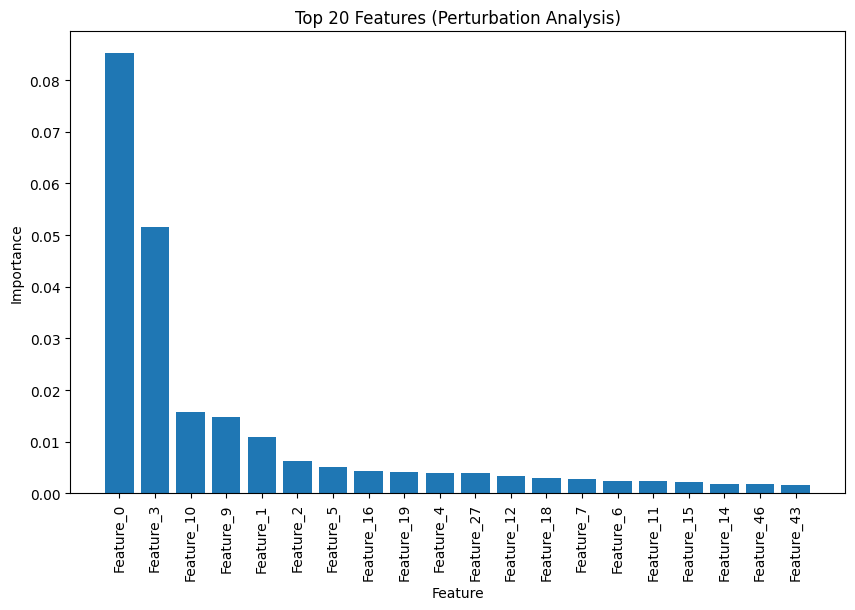

In [ ]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perturbation Analysis
def perturbation_analysis(model, X_test, feature_names):
    original_predictions = model.predict(X_test)
    original_rmse = calculate_rmse(y_test, original_predictions)
    importance_scores = []

    for i in range(X_test.shape[2]):  # Loop through features
        X_perturbed = X_test.copy()
        X_perturbed[:, :, i] = np.random.permutation(X_perturbed[:, :, i])  # Shuffle feature i
        perturbed_predictions = model.predict(X_perturbed)
        perturbed_rmse = calculate_rmse(y_test, perturbed_predictions)
        importance_scores.append(perturbed_rmse - original_rmse)  # Increase in RMSE indicates importance

    return importance_scores

# Apply Perturbation Analysis
feature_names = [f"Feature_{i}" for i in range(X_test.shape[2])]
perturb_scores = perturbation_analysis(best_model, X_test, feature_names)
plot_top_k_features(perturb_scores, feature_names, k=20, title="Top 20 Features (Perturbation Analysis)")

In [ ]:
def evaluate_model_performance(model, X_test, y_test, perturb_fn=None):
    if perturb_fn:
        X_test_perturbed = perturb_fn(X_test)
    else:
        X_test_perturbed = X_test  # No perturbation for baseline evaluation

    predictions_scaled = model.predict(X_test_perturbed)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_actual = scaler_y.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_actual, predictions))
    mae = mean_absolute_error(y_actual, predictions)

    return {"RMSE": rmse, "MAE": mae}

# Define a sample perturbation function (shuffling feature 0 as an example)
def sample_perturbation(X_test):
    X_test_perturbed = X_test.copy()
    X_test_perturbed[:, :, 0] = np.random.permutation(X_test[:, :, 0])  # Shuffle feature 0
    return X_test_perturbed

# Evaluate pre-perturbation performance
baseline_metrics = evaluate_model_performance(best_model, X_test, y_test)

# Evaluate post-perturbation performance using the sample perturbation
perturbed_metrics = evaluate_model_performance(best_model, X_test, y_test, perturb_fn=sample_perturbation)

# Log the results
print("Baseline Metrics:", baseline_metrics)
print("Post-Perturbation Metrics:", perturbed_metrics)
print("Performance Impact:", {
    "RMSE Change": perturbed_metrics["RMSE"] - baseline_metrics["RMSE"],
    "MAE Change": perturbed_metrics["MAE"] - baseline_metrics["MAE"]
})

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Baseline Metrics: {'RMSE': np.float32(1.1973723), 'MAE': np.float32(0.8552146)}
Post-Perturbation Metrics: {'RMSE': np.float32(4.481006), 'MAE': np.float32(3.3667643)}
Performance Impact: {'RMSE Change': np.float32(3.2836337), 'MAE Change': np.float32(2.5115497)}


Performance Impact:
RMSE Change (3.28) and MAE Change (2.51) confirm that the perturbation caused a meaningful loss of predictive accuracy.

Perturbations Target Key Features: When we perturb features identified as important, the model's predictive accuracy should degrade significantly. This confirms that the model relies heavily on those features for its predictions.

Loss of Accuracy Validates XAI: A significant drop in performance validates the XAI method's ability to correctly identify critical features. It proves that these features are influential for the model's predictions, aligning with your goal to evaluate and compare XAI methods.

In [ ]:
##LIME
X_test_reduced = np.mean(X_test, axis=1)  # Shape becomes (2096, 200)
X_train_reduced = np.mean(X_train, axis=1)  # Similarly reduce X_train
print("Reduced X_test shape:", X_test_reduced.shape)

feature_names = [f"Feature_{i}" for i in range(X_test_reduced.shape[1])]

explainer = LimeTabularExplainer(
    training_data=X_train_reduced,
    feature_names=feature_names,
    mode="regression"
)

def lime_predict_fn(data):
    # Reshape 2D data back to 3D with a single dummy time step
    data_3d = data[:, np.newaxis, :]  # Shape becomes (n_samples, 1, n_features)
    predictions = best_model.predict(data_3d)
    return predictions.flatten()

lime_feature_importances = np.zeros(X_test_reduced.shape[1])

for i in range(len(X_test_reduced)):
    explanation = explainer.explain_instance(
        data_row=X_test_reduced[i],
        predict_fn=lime_predict_fn
    )

    for feature, importance in explanation.as_list():
        try:
            feature_idx = int(re.search(r'Feature_(\d+)', feature).group(1))
            lime_feature_importances[feature_idx] += abs(importance)
        except (ValueError, IndexError, AttributeError) as e:
            print(f"Error parsing feature {feature}: {e}")

lime_feature_importances /= len(X_test_reduced)

Reduced X_test shape: (2096, 200)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0

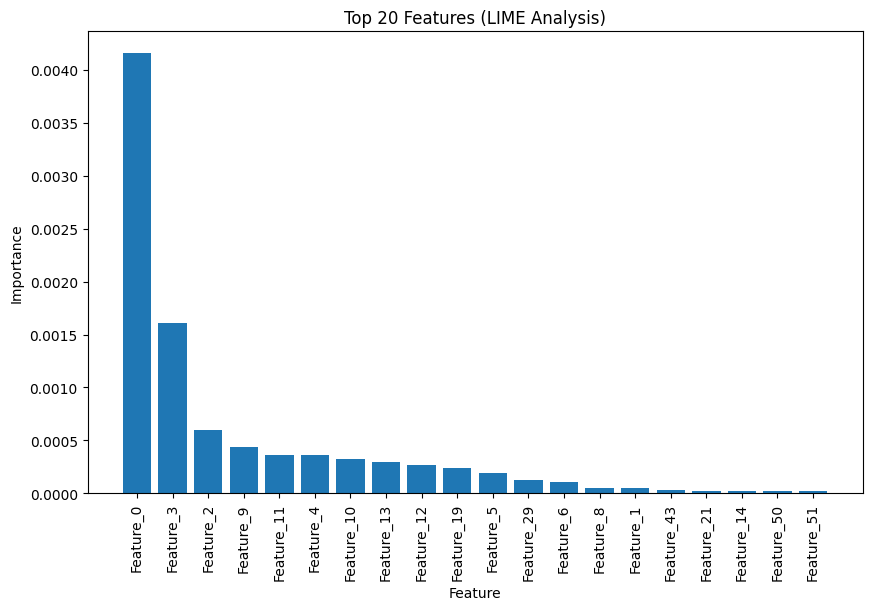

In [ ]:
plot_top_k_features(lime_feature_importances, feature_names, k=20, title="Top 20 Features (LIME Analysis)")

In [ ]:
# Select top-k features for perturbation based on LIME results
top_k_features_lime = np.argsort(-lime_feature_importances)[:10]

# Define perturbation function for LIME
def lime_perturbation(X_test, top_k_features):  # Applies perturbations to top-k features identified by LIME.
    X_test_perturbed = X_test.copy()
    for feature_idx in top_k_features:
        X_test_perturbed[:, :, feature_idx] = np.random.permutation(X_test[:, :, feature_idx])
    return X_test_perturbed

# Evaluate model performance after LIME-based perturbations
lime_perturbed_metrics = evaluate_model_performance(
    best_model,
    X_test,
    y_test,
    perturb_fn=lambda X: lime_perturbation(X, top_k_features_lime)
)

# Log LIME results
print("LIME Perturbation Metrics:", lime_perturbed_metrics)
print("LIME Performance Impact:", {
    "RMSE Change": lime_perturbed_metrics["RMSE"] - baseline_metrics["RMSE"],
    "MAE Change": lime_perturbed_metrics["MAE"] - baseline_metrics["MAE"]
})

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LIME Perturbation Metrics: {'RMSE': np.float32(5.7452083), 'MAE': np.float32(4.4501047)}
LIME Performance Impact: {'RMSE Change': np.float32(4.547836), 'MAE Change': np.float32(3.59489)}


Performance Impact:

RMSE Change (+4.55) and MAE Change (+3.59) highlight that LIME successfully identified critical features.
The model's performance degradation demonstrates LIME's fidelity in attributing importance to features.

The significant degradation validates that LIME accurately highlighted influential features.
Comparing this with the earlier perturbation analysis results (RMSE Change: 3.28, MAE Change: 2.51), LIME appears to target even more impactful features, which is expected given its finer-grained analysis.


Computing saliency map...


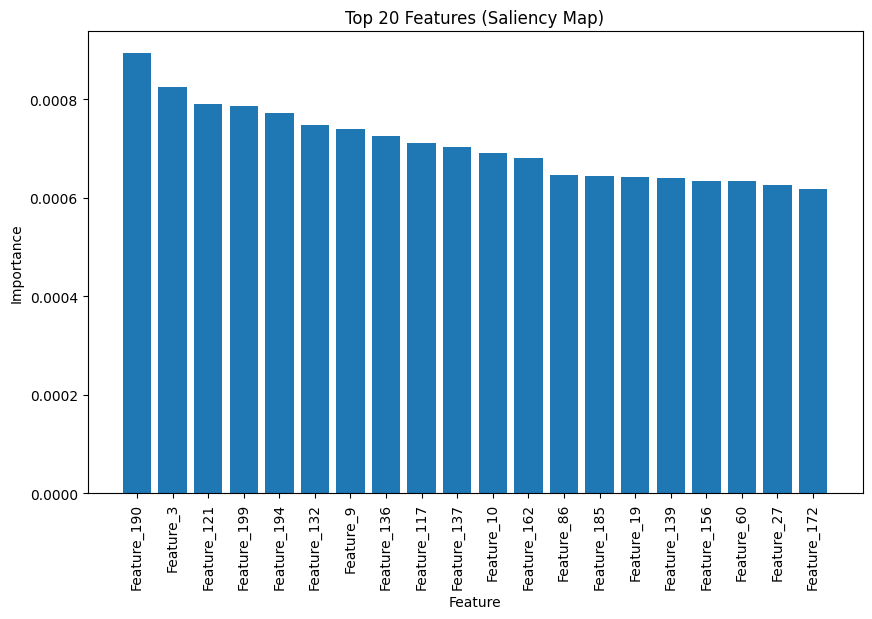

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Saliency Perturbation Metrics: {'RMSE': np.float32(3.7425656), 'MAE': np.float32(2.8526602)}
Saliency Performance Impact: {'RMSE Change': np.float32(2.5451932), 'MAE Change': np.float32(1.9974456)}


In [ ]:
# Define the saliency map computation function
def compute_saliency_map(model, X_input):
    # Computes the saliency map for the input data using the trained model.
    X_tensor = tf.convert_to_tensor(X_input)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)  # Forward pass
    gradients = tape.gradient(predictions, X_tensor)  # Compute gradients
    return gradients

# Define the saliency map application function
def apply_saliency_map(model, X_input, feature_names, top_k=10): # Apply saliency map to identify important features and plot the top-k features.

    # Step 1: Compute saliency map
    print("\nComputing saliency map...")
    gradients = compute_saliency_map(model, X_input)

    # Step 2: Aggregate gradient magnitudes
    saliency_scores = tf.reduce_mean(tf.abs(gradients), axis=(0, 1)).numpy()  # Average over samples and time steps

    # Step 3: Plot top-k features
    plot_top_k_features(
        saliency_scores,
        feature_names,
        k=top_k,
        title="Top 20 Features (Saliency Map)"
    )

    return saliency_scores

# Compute and visualize saliency map feature importances
feature_names = [f"Feature_{i}" for i in range(X_test.shape[2])]
saliency_scores = apply_saliency_map(best_model, X_test, feature_names, top_k=20)

# Select top-k features for perturbation based on saliency scores
top_k_features_saliency = np.argsort(-saliency_scores)[:20]

# Define perturbation function for saliency map
def saliency_perturbation(X_test, top_k_features):
    # Applies perturbations to top-k features identified by saliency maps.
    X_test_perturbed = X_test.copy()
    for feature_idx in top_k_features:
        X_test_perturbed[:, :, feature_idx] = np.random.permutation(X_test[:, :, feature_idx])
    return X_test_perturbed

# Evaluate model performance after saliency map-based perturbations
saliency_perturbed_metrics = evaluate_model_performance(
    best_model,
    X_test,
    y_test,
    perturb_fn=lambda X: saliency_perturbation(X, top_k_features_saliency)
)

# Log saliency map results
print("Saliency Perturbation Metrics:", saliency_perturbed_metrics)
print("Saliency Performance Impact:", {
    "RMSE Change": saliency_perturbed_metrics["RMSE"] - baseline_metrics["RMSE"],
    "MAE Change": saliency_perturbed_metrics["MAE"] - baseline_metrics["MAE"]
})


Saliency Perturbation Metrics:

RMSE (3.74) and MAE (2.85) after perturbing the top-20 features identified by the saliency map.
These metrics indicate a moderate degradation in performance compared to the baseline (RMSE: 1.19, MAE: 0.85).
Performance Impact:

RMSE Change (+2.55) and MAE Change (+1.99) reflect the model's reliance on the top-20 features identified by the saliency map.
The performance impact is less severe than that caused by LIME perturbations (RMSE Change: 4.55, MAE Change: 3.59), suggesting saliency maps identified features that are important but potentially less critical than those found by LIME.


Computing Integrated Gradients for all test samples...


Integrated Gradients Progress: 100%|██████████| 2096/2096 [01:49<00:00, 19.10it/s]


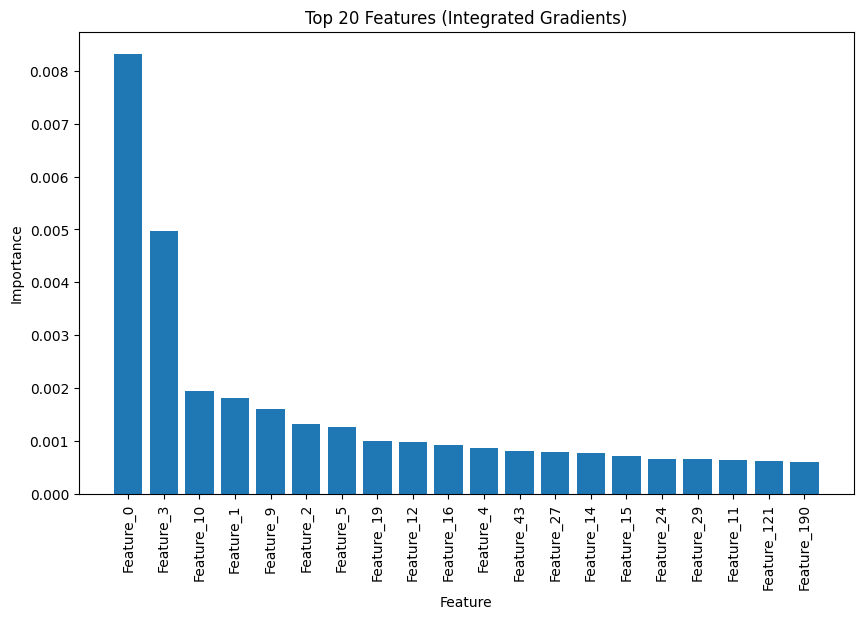

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Integrated Gradients Perturbation Metrics: {'RMSE': np.float32(5.9787626), 'MAE': np.float32(4.6793556)}
Integrated Gradients Performance Impact: {'RMSE Change': np.float32(4.78139), 'MAE Change': np.float32(3.824141)}


In [ ]:
def integrated_gradients(model, baseline, input_data, steps=50):
    scaled_inputs = [
        baseline + (float(i) / steps) * (input_data - baseline)
        for i in range(steps + 1)
    ]
    scaled_inputs = np.array(scaled_inputs)

    # Convert to TensorFlow tensors
    scaled_inputs_tensor = tf.convert_to_tensor(scaled_inputs)

    with tf.GradientTape() as tape:
        tape.watch(scaled_inputs_tensor)
        predictions = model(scaled_inputs_tensor)

    gradients = tape.gradient(predictions, scaled_inputs_tensor)  # Compute gradients
    avg_gradients = np.mean(gradients, axis=0)  # Average gradients across steps
    integrated_gradients = (input_data - baseline) * avg_gradients  # Multiply by input difference

    return integrated_gradients

# Prepare baseline (e.g., zeros or mean of dataset)
baseline = np.zeros_like(X_test[0])  # Using all-zero baseline

# Initialize array for IG attributions
ig_attributions = np.zeros_like(X_test)

# Compute Integrated Gradients for test data with progress bar
print("\nComputing Integrated Gradients for all test samples...")
for i, sample in tqdm(enumerate(X_test), total=len(X_test), desc="Integrated Gradients Progress"):
    ig_attributions[i] = integrated_gradients(best_model, baseline, sample)

# Aggregate IG attributions across time and features
ig_feature_importances = np.mean(np.abs(ig_attributions), axis=(0, 1))  # Average over samples and time steps

# Visualize IG feature importances
plot_top_k_features(ig_feature_importances, feature_names, k=20, title="Top 20 Features (Integrated Gradients)")

# Perturb top-k features identified by IG
top_k_features_ig = np.argsort(-ig_feature_importances)[:20]

def ig_perturbation(X_test, top_k_features):
    """
    Perturbs top-k features identified by Integrated Gradients.
    """
    X_test_perturbed = X_test.copy()
    for feature_idx in top_k_features:
        X_test_perturbed[:, :, feature_idx] = np.random.permutation(X_test[:, :, feature_idx])
    return X_test_perturbed

# Evaluate model performance after IG-based perturbations
ig_perturbed_metrics = evaluate_model_performance(
    best_model,
    X_test,
    y_test,
    perturb_fn=lambda X: ig_perturbation(X, top_k_features_ig)
)

# Log IG results
print("Integrated Gradients Perturbation Metrics:", ig_perturbed_metrics)
print("Integrated Gradients Performance Impact:", {
    "RMSE Change": ig_perturbed_metrics["RMSE"] - baseline_metrics["RMSE"],
    "MAE Change": ig_perturbed_metrics["MAE"] - baseline_metrics["MAE"]
})


Performance Impact:

RMSE Change (+4.78) and MAE Change (+3.82) are the highest observed among the XAI methods so far.
This suggests that IG successfully identified highly critical features for the model's predictions.

XAI Method	RMSE Change	MAE Change

Original Perturbation	+3.28	+2.51

LIME	+4.55	+3.59

Saliency Maps	+2.55	+1.99

Integrated Gradients (IG)	+4.78	+3.82


Observations:
Integrated Gradients: Highest performance impact, indicating it identified the most critical features.
LIME: Second-highest impact, close to IG, showing effective identification of impactful features.
Saliency Maps: More conservative in identifying critical features, leading to a lower performance impact.
Original Perturbation: Serves as a benchmark but lacks the specificity of XAI methods.

In [ ]:
# Function to calculate fidelity
def calculate_fidelity(baseline_metrics, perturbed_metrics):
    """
    Calculates fidelity based on RMSE changes.
    """
    fidelity = (perturbed_metrics["RMSE"] - baseline_metrics["RMSE"]) / baseline_metrics["RMSE"]
    return fidelity

# Fidelity Calculations
# Fidelity for LIME
lime_fidelity = calculate_fidelity(baseline_metrics, lime_perturbed_metrics)
print("LIME Fidelity:", lime_fidelity)

# Fidelity for Saliency Maps
saliency_fidelity = calculate_fidelity(baseline_metrics, saliency_perturbed_metrics)
print("Saliency Map Fidelity:", saliency_fidelity)

# Fidelity for Integrated Gradients
ig_fidelity = calculate_fidelity(baseline_metrics, ig_perturbed_metrics)
print("Integrated Gradients Fidelity:", ig_fidelity)

# Function to calculate Euclidean distance
def calculate_euclidean_distance(original, perturbed):
    """
    Calculates the Euclidean distance between the original and perturbed datasets.
    """
    distances = []
    for i in range(original.shape[0]):  # Iterate over samples
        distances.append(euclidean(original[i].flatten(), perturbed[i].flatten()))
    return np.mean(distances)  # Return the average distance

# Euclidean Distance Calculations
# Calculate Euclidean distance for LIME perturbation
lime_perturbed_data = lime_perturbation(X_test, top_k_features_lime)
lime_euclidean_distance = calculate_euclidean_distance(X_test, lime_perturbed_data)
print("LIME Euclidean Distance:", lime_euclidean_distance)

# Calculate Euclidean distance for Saliency Map perturbation
saliency_perturbed_data = saliency_perturbation(X_test, top_k_features_saliency)
saliency_euclidean_distance = calculate_euclidean_distance(X_test, saliency_perturbed_data)
print("Saliency Map Euclidean Distance:", saliency_euclidean_distance)

# Calculate Euclidean distance for Integrated Gradients perturbation
ig_perturbed_data = ig_perturbation(X_test, top_k_features_ig)
ig_euclidean_distance = calculate_euclidean_distance(X_test, ig_perturbed_data)
print("Integrated Gradients Euclidean Distance:", ig_euclidean_distance)

# Logging results
print("\nFidelity and Euclidean Distance Summary:")
print(f"LIME: Fidelity = {lime_fidelity:.4f}, Euclidean Distance = {lime_euclidean_distance:.4f}")
print(f"Saliency Maps: Fidelity = {saliency_fidelity:.4f}, Euclidean Distance = {saliency_euclidean_distance:.4f}")
print(f"Integrated Gradients: Fidelity = {ig_fidelity:.4f}, Euclidean Distance = {ig_euclidean_distance:.4f}")


LIME Fidelity: 3.79818
Saliency Map Fidelity: 2.125649
Integrated Gradients Fidelity: 3.993236
LIME Euclidean Distance: 134.84259971498534
Saliency Map Euclidean Distance: 42.247669025231865
Integrated Gradients Euclidean Distance: 157.62073970387002

Fidelity and Euclidean Distance Summary:
LIME: Fidelity = 3.7982, Euclidean Distance = 134.8426
Saliency Maps: Fidelity = 2.1256, Euclidean Distance = 42.2477
Integrated Gradients: Fidelity = 3.9932, Euclidean Distance = 157.6207


Trade-off Between Fidelity and Perturbation Extremity:

IG and LIME demonstrate high fidelity but at the cost of larger perturbations, as evidenced by higher Euclidean distances.
Saliency Maps identify less critical features but result in smaller perturbations, maintaining more similarity to the original dataset.
Integrated Gradients (IG) Performance:

IG stands out as the most effective method in identifying highly critical features, as reflected by its highest fidelity and largest performance impact.
LIME Performance:

LIME also performs well, offering a balance between fidelity and perturbation impact, though slightly less impactful than IG.
Saliency Maps:

Saliency Maps are more cautious and produce smaller perturbations, which could be useful in applications requiring minimal data alterations but might miss highly impactful features.


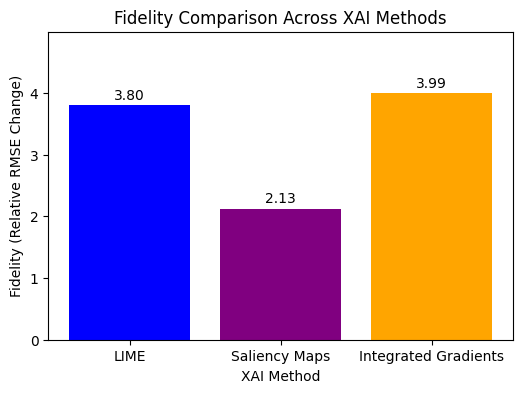

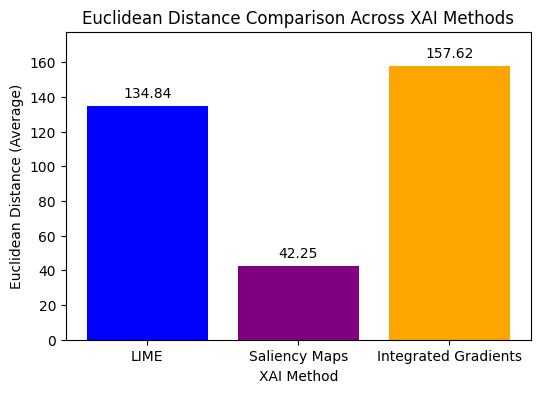

In [ ]:
# Data
methods = ["LIME", "Saliency Maps", "Integrated Gradients"]
fidelities = [lime_fidelity, saliency_fidelity, ig_fidelity]
euclidean_distances = [lime_euclidean_distance, saliency_euclidean_distance, ig_euclidean_distance]

# Bar Plot for Fidelity
plt.figure(figsize=(6, 4))
plt.bar(methods, fidelities, color=['blue', 'purple', 'orange'])
plt.title("Fidelity Comparison Across XAI Methods")
plt.xlabel("XAI Method")
plt.ylabel("Fidelity (Relative RMSE Change)")
for i, fidelity in enumerate(fidelities):
    plt.text(i, fidelity + 0.1, f"{fidelity:.2f}", ha='center')
plt.ylim(0, max(fidelities) + 1)
plt.show()

# Bar Plot for Euclidean Distance
plt.figure(figsize=(6, 4))
plt.bar(methods, euclidean_distances, color=['blue', 'purple', 'orange'])
plt.title("Euclidean Distance Comparison Across XAI Methods")
plt.xlabel("XAI Method")
plt.ylabel("Euclidean Distance (Average)")
for i, distance in enumerate(euclidean_distances):
    plt.text(i, distance + 5, f"{distance:.2f}", ha='center')
plt.ylim(0, max(euclidean_distances) + 20)
plt.show()

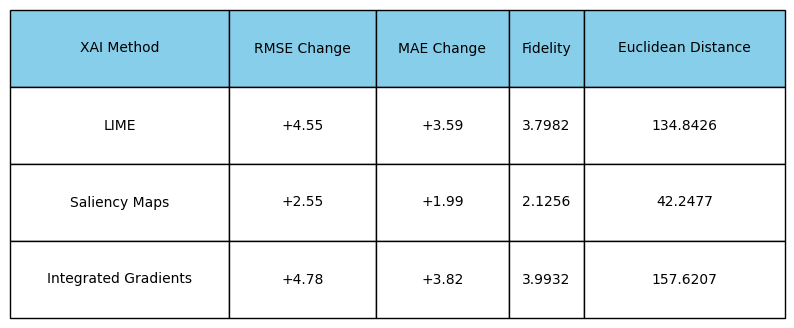

In [ ]:
# Data for the table
data = {
    "XAI Method": ["LIME", "Saliency Maps", "Integrated Gradients"],
    "RMSE Change": ["+4.55", "+2.55", "+4.78"],
    "MAE Change": ["+3.59", "+1.99", "+3.82"],
    "Fidelity": ["3.7982", "2.1256", "3.9932"],
    "Euclidean Distance": ["134.8426", "42.2477", "157.6207"]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')  # Hide axes

# Create the table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=["skyblue"] * len(df.columns),
    bbox=[0, 0, 1, 1]  # Adjust size
)

# Style adjustments
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Show the plot
plt.show()